In [1]:
!git clone https://github.com/Godwin45/Track1

Cloning into 'Track1'...
remote: Enumerating objects: 28562, done.
remote: Total 28562 (delta 0), reused 0 (delta 0), pack-reused 28562
Receiving objects: 100% (28562/28562), 365.72 MiB | 32.83 MiB/s, done.
Checking out files: 100% (28567/28567), done.


In [2]:
!ls Track1

driving_log.csv  IMG


In [3]:
!pip3 install imgaug

In [51]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random
import ntpath
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split

In [16]:
datadir = 'Track1'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'),names = columns)
#pd.set_option('display.max_colwidth', None)
data.head()

center  ...     speed
0  C:\Users\User\Desktop\car picture\IMG\center_2...  ...  0.000079
1  C:\Users\User\Desktop\car picture\IMG\center_2...  ...  0.000080
2  C:\Users\User\Desktop\car picture\IMG\center_2...  ...  0.000080
3  C:\Users\User\Desktop\car picture\IMG\center_2...  ...  0.000079
4  C:\Users\User\Desktop\car picture\IMG\center_2...  ...  0.015985

[5 rows x 7 columns]

In [17]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2021_01_31_12_12_01_852.jpg  ...  0.000079
1  center_2021_01_31_12_12_01_955.jpg  ...  0.000080
2  center_2021_01_31_12_12_02_058.jpg  ...  0.000080
3  center_2021_01_31_12_12_02_163.jpg  ...  0.000079
4  center_2021_01_31_12_12_02_266.jpg  ...  0.015985

[5 rows x 7 columns]

<BarContainer object of 25 artists>

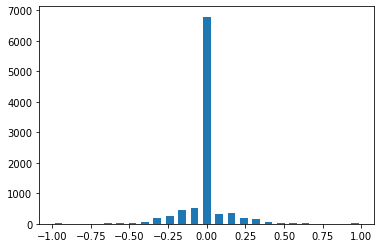

In [18]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
#print(bins)
plt.bar(center, hist, width = 0.05)

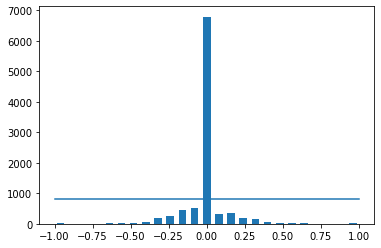

In [19]:
num_bins = 25
samples_per_bin = 800
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 9522
removed: 5989
remaining: 3533


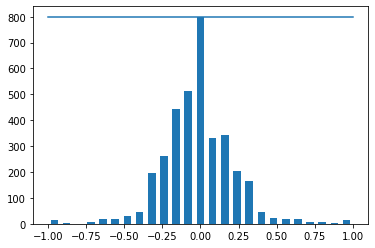

In [20]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [38]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steerings)
  return image_paths, steerings

center      center_2021_01_31_12_12_02_785.jpg
left          left_2021_01_31_12_12_02_785.jpg
right        right_2021_01_31_12_12_02_785.jpg
steering                             -0.204545
throttle                                     1
reverse                                      0
speed                                  4.51946
Name: 9, dtype: object


In [39]:
 x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2)
print('Training Samples: {}\nValid Samples: {}'.format(len(x_train), len(x_valid)))

Training Samples: 8479
Valid Samples: 2120


Text(0.5, 1.0, 'Validation set')

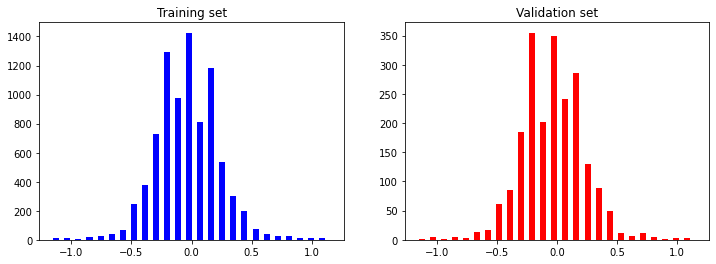

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [41]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:130, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255

  return img

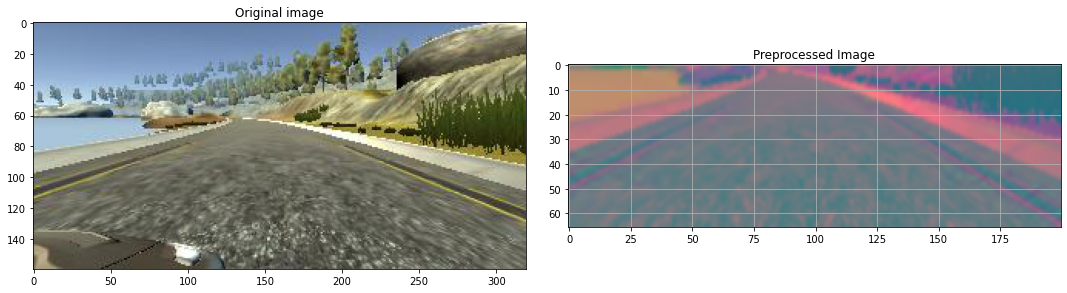

In [42]:
image = image_paths[200]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
plt.grid('on')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')
plt.grid('on')

In [43]:
x_train = np.array(list(map(img_preprocess, x_train)))
x_valid = np.array(list(map(img_preprocess, x_valid)))

(8479, 66, 200, 3)


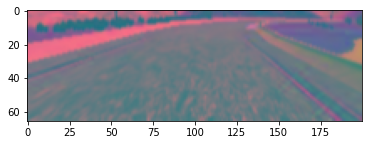

In [50]:
plt.imshow(x_train[random.randint(0, len(x_train) - 1)])
print(x_train.shape)

PERFORMING DATA AUGMENTATION WHILE CREATING A DATA GENERATOR

In [52]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image 

Text(0.5, 1.0, 'zoomed image')

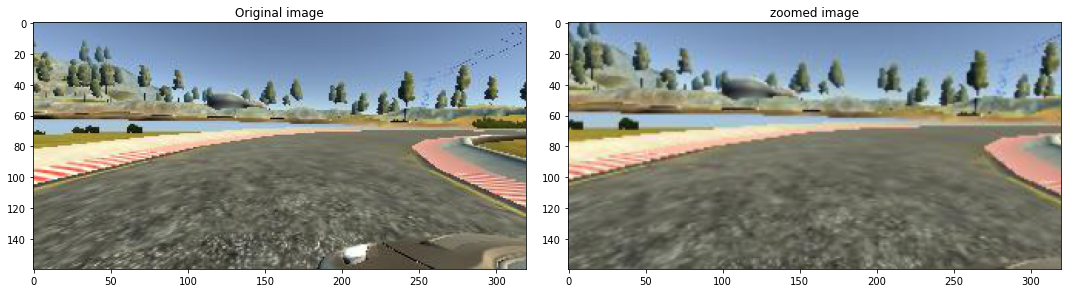

In [53]:
image = image_paths[random.randint(0, 8478)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed image')

In [54]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image 

Text(0.5, 1.0, 'Panned image')

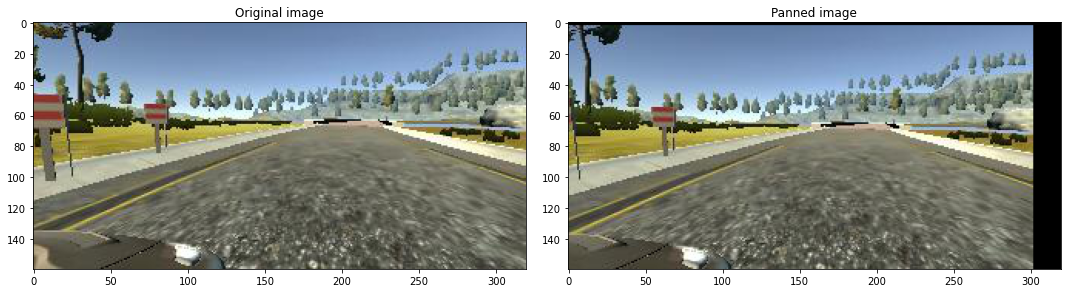

In [57]:
image = image_paths[random.randint(0, 8478)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [58]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

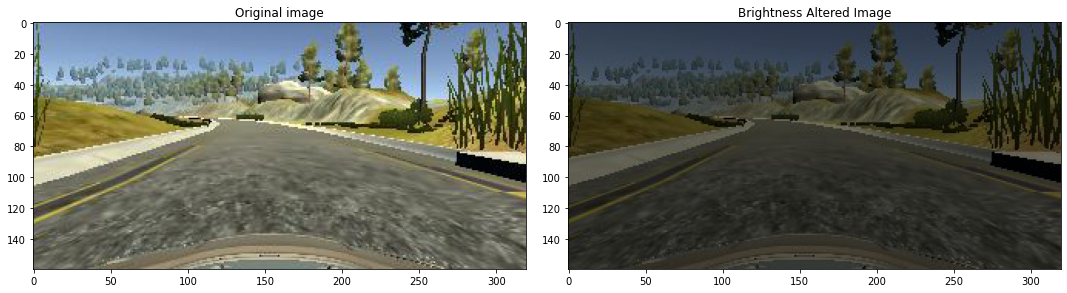

In [62]:
image = image_paths[random.randint(0, 8478)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [63]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle-0.21345271')

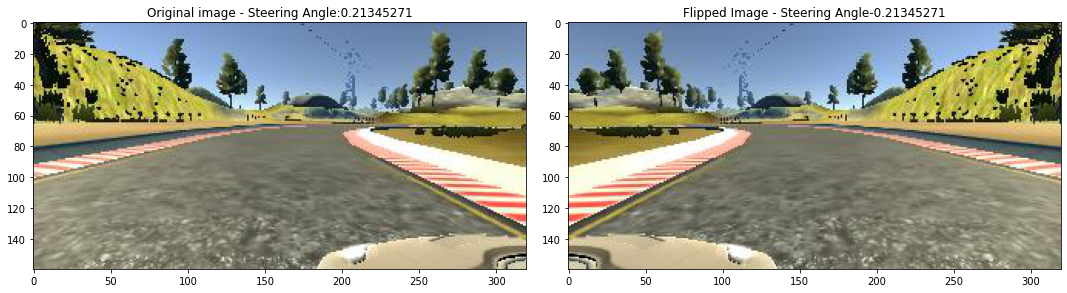

In [66]:
random_index = random.randint(0, 8478)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image,steering_angle)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle' + str(flipped_steering_angle))

In [71]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image = image, steering_angle = img_random_flip(image, steering_angle)
  
  return image, steering_angle

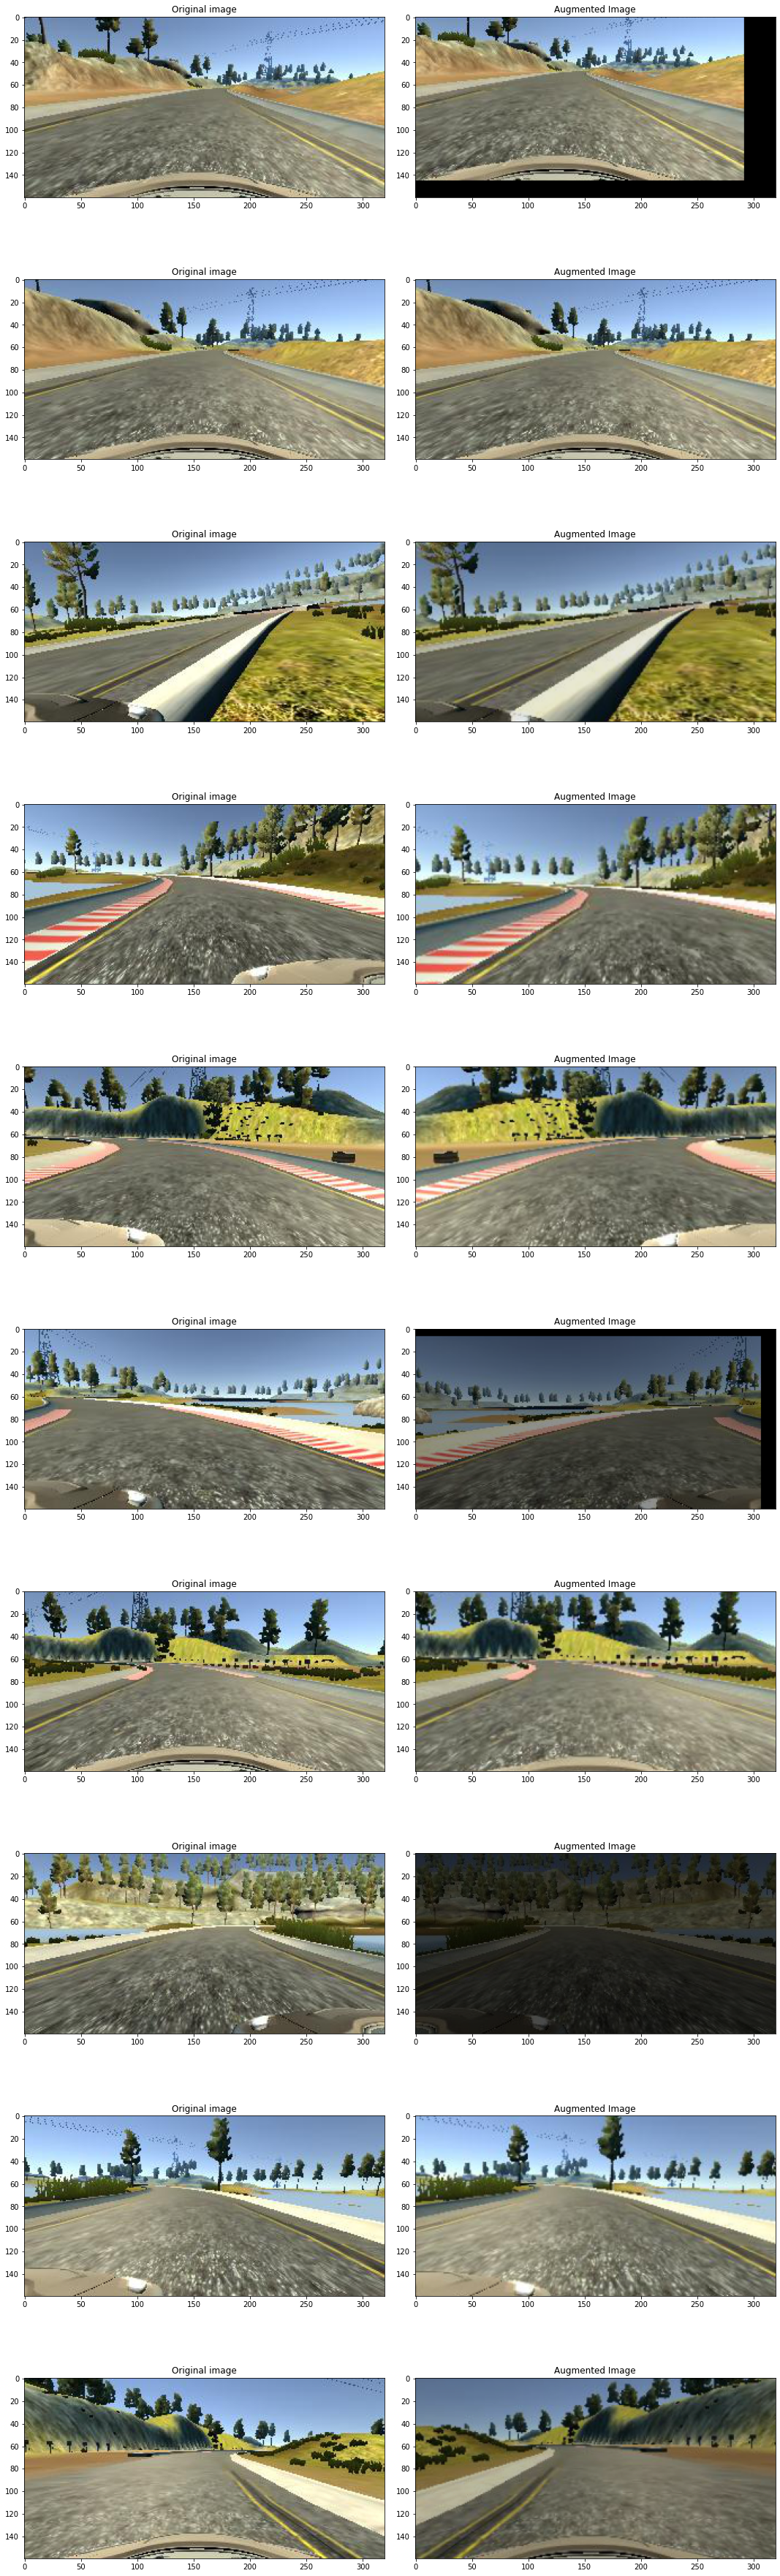

In [73]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize = (15, 50))
fig.tight_layout()
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)

  random_image  = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')